# Handwritten Digit Classification using CNN in PyTorch

This Jupyter Notebook implements a Convolutional Neural Network (CNN) to classify handwritten digits using the MNIST dataset in CSV format.
It includes the following steps:
- Loading and preprocessing the dataset
- Defining the CNN model
- Training the model
- Evaluating performance
- Visualizing predictions on random images

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import clear_output

# Step 1: Load and Preprocess the MNIST CSV Dataset

MNIST dataset is in CSV format, where:
- The first column contains labels (digits 0-9)
- The remaining columns contain pixel values (0-255), representing a 28x28 grayscale image

We normalize pixel values to range [0,1] and convert them into tensors suitable for training.

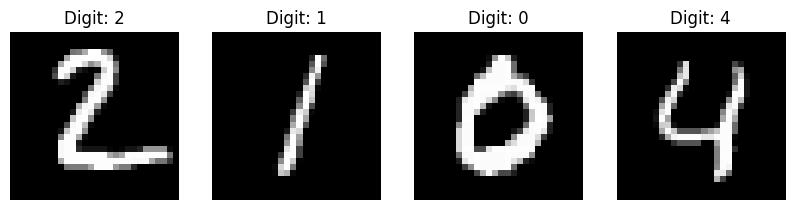

In [2]:
mnist = pd.read_csv("sample_data/mnist_test.csv")  # Ensure you have the dataset
labels = mnist.iloc[:, 0].values  # First column contains labels
images = mnist.iloc[:, 1:].values / 255.0  # Normalize pixel values (0-255 -> 0-1)

# Display first 4 images
fig, axes = plt.subplots(1, 4, figsize=(10, 5))  # 1 row, 4 columns

for i in range(4):
    label = labels[i]

    # Plot each image
    axes[i].imshow(images[i].reshape(28, 28), cmap="gray")
    axes[i].set_title(f"Digit: {label}")
    axes[i].axis("off")

plt.show()  # Display images

# Convert to PyTorch tensors

In [3]:
X = torch.tensor(images, dtype=torch.float32).view(-1, 1, 28, 28)  # Reshape for CNN
Y = torch.tensor(labels, dtype=torch.long)

dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))  # 80% train, 20% validation
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Step 2: Define the CNN Model
Convolutional Neural Network (CNN) architecture:
- 2 Conv layers followed by ReLU activation and MaxPooling
- Fully connected layers to classify digits 0-9

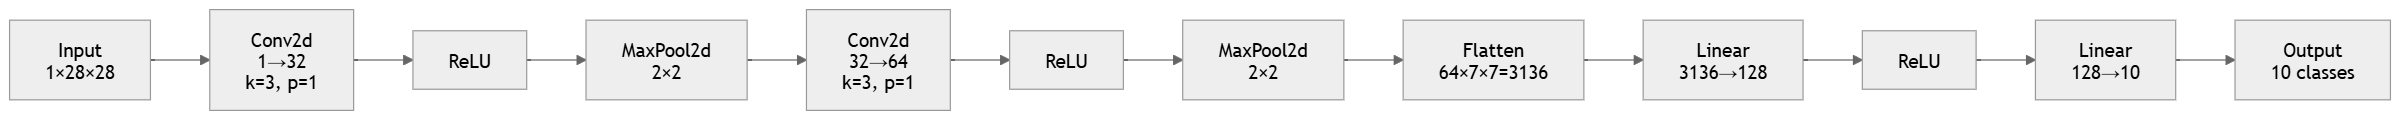

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Initialize Model, Loss, and Optimizer

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the Model

In [6]:
# Track metrics
epochs = 5
loss_history = []
accuracy_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Track accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total * 100
    loss_history.append(avg_loss)
    accuracy_history.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/5, Loss: 0.6607, Accuracy: 79.67%
Epoch 2/5, Loss: 0.1722, Accuracy: 94.64%
Epoch 3/5, Loss: 0.1070, Accuracy: 96.61%
Epoch 4/5, Loss: 0.0696, Accuracy: 97.94%
Epoch 5/5, Loss: 0.0523, Accuracy: 98.29%


# Metrices

### Plot Loss Curve

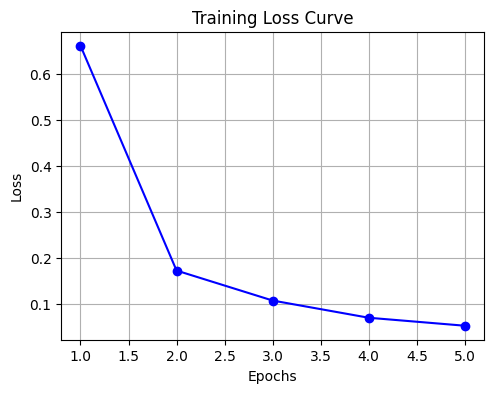

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), loss_history, marker="o", linestyle="-", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()

### Plot Accuracy Curve

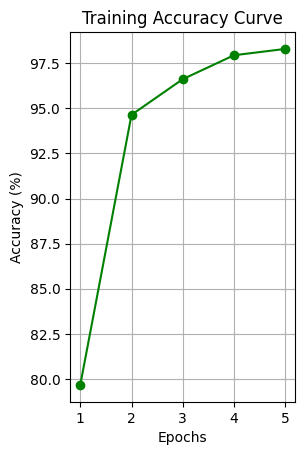

In [8]:
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), accuracy_history, marker="o", linestyle="-", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Curve")
plt.grid()
plt.show()

### Confusion Matrix

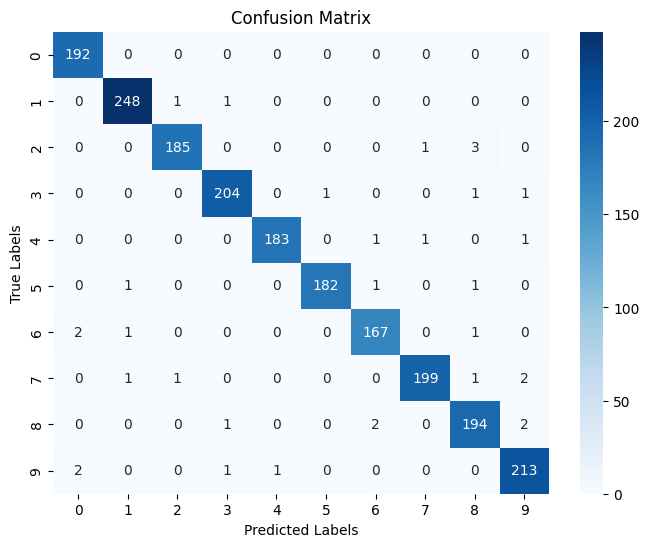

In [9]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Step 5: Pick 10 Random Images and Display Predictions

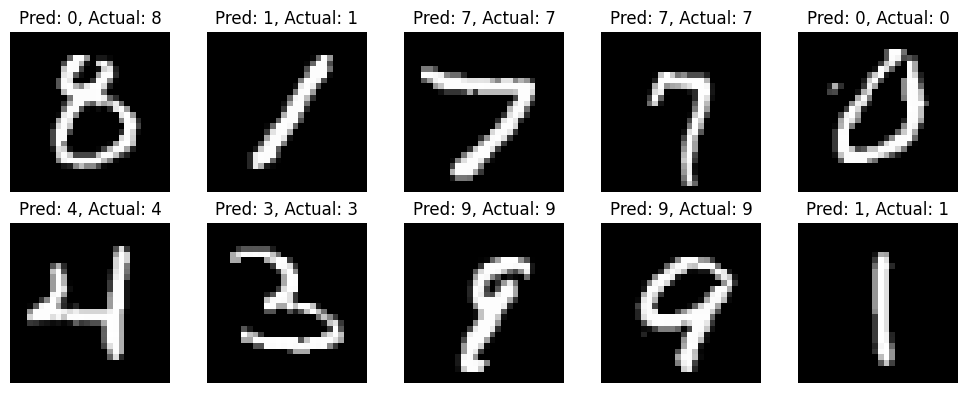

In [10]:
import random
model.eval()
samples = random.sample(range(len(train_dataset)), 10)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, idx in enumerate(samples):
    image, label = train_dataset[idx]
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = torch.argmax(model(image)).item()

    ax = axes[i // 5, i % 5]
    ax.imshow(image.cpu().squeeze(), cmap='gray')
    ax.set_title(f"Pred: {prediction}, Actual: {label.item()}")
    ax.axis("off")

plt.tight_layout()
plt.show()